# Cleaning Data for Project 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def rename_col(col_name):
    years_list = list(range(2010,2017))
    col_list = ["CountyName"]
    for year in years_list:
        col_list.append(col_name+ "_{}".format(year))
    return col_list

def year_col():
    years_list = list(range(2010,2017))
    col_list = []
    for year in years_list:
        col_list.append("{}".format(year))
    return col_list

def rename_headers(df,col_name):
    level_headers(df)
    df.columns = rename_col(col_name)

def level_headers(df):
    df.reset_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

## Reading & Cleaning Data

### 1) Price-to-rent data

In [3]:
pr = pd.read_csv("pricetorentratio.csv")

In [4]:
# extracting CA real estate data from US real estate data using CA zip codes
ca_zip = pd.read_csv("CAzipcodes.csv")

In [5]:
# change zip_code column name to match "RegionName" in price-to-rent dataset
ca_zip.columns = ["RegionName"]

In [6]:
# merge ca_zip & pr to extract CA price-to-rent data, save merged dataframe into new variable "ca_pr"
ca_pr = pd.merge(pr,ca_zip)

year_list = list(range(2010,2019))
for year in year_list:
    ca_pr[str(year)] = 0

index = 0
for year in ca_pr.iloc[:,7:].columns.values:
    if "-01" in year:
        index += 1
    else:
        ca_pr[str(year_list[index])] += ca_pr[year]

ca_pr = ca_pr[["CountyName","2010","2011","2012","2013","2014","2015","2016"]]

ca_pr = ca_pr.groupby(["CountyName"]).mean()

#rename_headers(ca_pr,"Price_to_Rent")
level_headers(ca_pr)

for year in ca_pr.iloc[:,1:].columns.values:
    if "_2010" in year:
        ca_pr[year] = ca_pr[year].apply(lambda x: (x*4)/12)
    else:
        ca_pr[year] = ca_pr[year].apply(lambda x: x/12)

### 2) Unemployment Rate (%) 2010-2016

In [7]:
path = os.getcwd()
files = os.listdir(path)
lfd_xlsx = [f for f in files if f[-4:]=='xlsx' and f[0:3]=='lfd']
lfd = pd.DataFrame()
for f in lfd_xlsx:
    data = pd.read_excel(f)
    lfd = lfd.append(data)
    
lfd.columns = lfd.iloc[4]
lfd.columns = ['LAUS','2011','2012','2013','2014','2015','2016','STATEFIPSCODE','COUNTYFIPSCODE','COUNTYNAME/STATEABBR','YEAR','_','LABORFORCE','EMPLOYED','UNEMPLOYED','UNEMPLOYMENTRATE(%)']
lfd = lfd.iloc[5:]
lfd['CountyName'],lfd['STATEABBR'] = lfd['COUNTYNAME/STATEABBR'].str.split(',',1).str
lfd = lfd.drop(lfd.columns[[0,1,2,3,4,5,6,7,8,9,11]],axis=1)
lfd = lfd.dropna(how="any")
lfd = lfd.loc[lfd['STATEABBR']==' CA']

In [8]:
# changing county names to match price-to-rent county names for merge
lfd["CountyName"] = lfd["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
# extract unemployment rate (%) per year
unemployment_rate = lfd.pivot_table(index="CountyName",columns="YEAR",values=["UNEMPLOYMENTRATE(%)"],aggfunc="first")
rename_headers(unemployment_rate,"UnemploymentRate(%)")

### 3) Population Total 2010-2016

In [9]:
f = pd.ExcelFile("CAcountypop.xlsx")
pop = pd.DataFrame()
year = 2010
for sheet in f.sheet_names:
    if "E5CountyState" in sheet and "2017" not in sheet:
            sub_pop = pd.read_excel(f,sheet,skiprows=3).assign(Year=year)
            pop = pop.append(sub_pop)
            year += 1
    
pop = pop[["COUNTY","Total","Total.1","Vacancy Rate","Year"]]
pop.columns = ["CountyName","Population Total","Housing Units Total","Vacancy Rate","Year"]
pop = pop.drop(pop.index[[59]])
pop = pop.dropna(how="any")

In [10]:
# extract population totals per year
pop_year = pop.pivot_table(index="CountyName",columns="Year",values=["Population Total"],aggfunc="first")
rename_headers(pop_year,"Total_Population")

 ### 4) Vacancy Rate 2010-2016

In [11]:
vacancy_year = pop.pivot_table(index="CountyName",columns="Year",values=["Vacancy Rate"],aggfunc="first")
rename_headers(vacancy_year,"Vacancy_Rate")

### 5) Housing Units 2010-2016

In [12]:
housing_units_year = pop.pivot_table(index="CountyName",columns="Year",values=["Housing Units Total"],aggfunc="first")
rename_headers(housing_units_year,"Total_Housing_Units")

### 6) Crime Rate 2010-2016

In [13]:
crime = pd.read_csv("CAcrimes.csv",sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
# change dtype for dataframe fr. objects to integers
crime = crime.apply(pd.to_numeric,errors="ignore")
# change persistent object types to integers 
crime_obj = ["TotalStructural_sum","TotalMobile_sum","TotalOther_sum","GrandTotal_sum","GrandTotClr_sum"]
for obj in crime_obj:
    crime[obj] = pd.to_numeric(crime[obj],errors="coerce")
# sum selected column data for total crime
col_list = list(crime)
col_list = [col for col in col_list if col not in {'Year','County','NCICCode'}]
crime["Total Crime"] = crime[col_list].sum(axis=1)
# select only Years 2010-2016
crime = crime[(crime["Year"] >= 2010) & (crime["Year"] < 2017)]
crime = crime.rename(columns={"County":"CountyName"})
crime["CountyName"] = crime["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))

In [14]:
# consolidate total crimes per year
crime_year = crime.pivot_table(index="CountyName",columns="Year",values=["Total Crime"],aggfunc="first")
level_headers(crime_year)

In [15]:
# calculate crime rate 
crime_rate = crime_year.iloc[:,1:]/pop_year.iloc[:,1:].values
#crime_rate.columns = rename_col()
rename_headers(crime_rate,"Crime_Rate")
crime_rate["CountyName"] = crime_year["CountyName"]

### 7) School Total 2010-2016

#### A) Private Schools

In [16]:
ps_xls = [f for f in files if f[-3:]=='xls' and f[0:2]=='ps']
ps_data = pd.DataFrame()
year = 2010
for f in ps_xls:
    data = pd.read_excel(f,skiprows=3).assign(Year=year)
    ps_data = ps_data.append(data)
    year += 1

ps_data = ps_data[["County","Year"]]
ps_data = ps_data.dropna(how="any")
ps_data["Private_School_Count"] = 1
ps_data = ps_data.rename(columns={"County":"CountyName"})

In [17]:
# modify data to extract number of private schools per year
ps = ps_data.pivot_table(index="CountyName",columns="Year",values=["Private_School_Count"],aggfunc="sum")
ps = ps.fillna(0)
ps_year = ps
level_headers(ps_year)
ps_year = ps_year.drop(ps_year.index[[51]])

#### B) Public Schools

In [18]:
pubs_data = pd.read_excel("pubschls.xlsx")

pubs_data = pubs_data[["County","OpenDate","ClosedDate","LastUpDate"]]
pubs_data["TMP"] = pubs_data.OpenDate.values # create temporary column out of the index
pubs_data = pubs_data[pubs_data.TMP.notnull()] # remove all NaT values
pubs_data.drop(["TMP"], axis=1, inplace=True) # delete temporary column 
pubs_data["OpenYear"] = pd.DatetimeIndex(pubs_data['OpenDate']).year
pubs_data["ClosedYear"] = pd.DatetimeIndex(pubs_data['ClosedDate']).year
for year in range(2010, 2017):
    # Create a column of 0s
    pubs_data[year] = 0
    # Where the year is between OpenYear and ClosedYear (or closed year is NaN) set it to 1
    pubs_data.loc[(pubs_data['OpenYear'] <= year) & ((pubs_data['ClosedYear'].isnull()) | (pubs_data['ClosedYear'] >= year)), year] += int(1)
pubs_data = pubs_data.rename(columns={"County":"CountyName"})

In [19]:
# consolidate number of public schools per year
pubs_year = pubs_data[["CountyName",2010,2011,2012,2013,2014,2015,2016]]
pubs_year = pubs_year.groupby(["CountyName"]).sum()
level_headers(pubs_year)

#### C) Total Number of Schools

In [20]:
col_list = ["CountyName","2010","2011","2012","2013","2014","2015","2016"]
pub = pubs_year
pub.columns = col_list
priv = ps
#priv.reset_index(inplace=True)
priv.columns = priv.columns.get_level_values(0)
priv.columns = col_list

# add public schools and private schools together to get total number of schools per year
sch_total = pub.iloc[:,1:].add(priv.iloc[:,1:],fill_value=0)

#rename_headers(sch_total,"Total_Schools")
sch_total["CountyName"] = pub["CountyName"]

### 8) Building Permits 2010-2016

In [21]:
bp_xls = [f for f in files if f[-3:]=='csv' and f[0:2]=='bp']
bp_data = pd.DataFrame()
for f in bp_xls:
    data = pd.read_csv(f,sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
    bp_data = bp_data.append(data)

bp_data = bp_data.iloc[2:,:]
bp_data = bp_data[["Survey","FIPS","County","Unnamed: 6","Unnamed: 9","Unnamed: 12","Unnamed: 15"]]
# extract CA building permits fr. US data
bp_data["FIPS"] = bp_data["FIPS"].apply(pd.to_numeric,errors="coerce")
bp_data = bp_data[bp_data["FIPS"]==6]
bp_data.columns = ["Year","FIPS","CountyName","1_unit_bldgs","2_unit_bldgs","3-4_unit_bldgs","5+_unit_bldgs"]
#change data type for bldg columns fr. object to integer
for col in bp_data.columns.values[3:]:
    bp_data[col] = bp_data[col].apply(pd.to_numeric,errors="coerce")
# sum bldg columns to get total building permits column 
col_list = list(bp_data)
col_list = [col for col in col_list if col not in {'Year','CountyName'}]
bp_data["Total_bldgs"] = bp_data[col_list].sum(axis=1)
bp_data["CountyName"] = bp_data["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))

In [22]:
# extract building permits per county per year
bp_year = bp_data.pivot_table(index="CountyName",columns="Year",values=["Total_bldgs"],aggfunc="sum")
rename_headers(bp_year,"Total_Building_Permits")

### 9) Average Property Tax Rate 2010-2016

In [23]:
ptax_xlsx = [f for f in files if f[-4:]=='xlsx' and f[0:2]=='pt']
ptax_data1 = pd.DataFrame()
ptax_data2 = pd.DataFrame()
year = 2010
for f in ptax_xlsx:
    if "10" in f or "11" in f:
        data = pd.read_excel(f,skiprows=8).assign(Year=year)
        ptax_data1 = ptax_data1.append(data)
    else:
        data = pd.read_excel(f,skiprows=4).assign(Year=year)
        ptax_data2 = ptax_data2.append(data)
    year += 1

ptax_data1 = ptax_data1[["1","8","Year"]]
ptax_data1.columns = ["CountyName","Average Property Tax Rate","Year"]

ptax_data2 = ptax_data2[["County  ","Average \ntax rate","Year"]]
ptax_data2.columns = ["CountyName","Average Property Tax Rate","Year"]

ptax_data = pd.DataFrame()
ptax_data = ptax_data.append(ptax_data1)
ptax_data = ptax_data.append(ptax_data2)

In [24]:
# extract average property tax per year 
ptax_year = ptax_data.pivot_table(index="CountyName",columns="Year",values=["Average Property Tax Rate"],aggfunc="first")
ptax_year = ptax_year.dropna(how="any")
rename_headers(ptax_year,"Average_Property_Tax")

### 10) Job Growth 2010-2016

In [25]:
bg_xls = [f for f in files if f[-3:]=='xls' and f[0:2]=='bg']
bg_data = pd.DataFrame()
year = 2010
for f in bg_xls:
    data = pd.read_excel(f,skiprows=7).assign(Year=year)
    bg_data = bg_data.append(data)
    year += 1

bg_data = bg_data.drop(bg_data.columns[[0,1,12,13,14]],axis=1)
bg_data = bg_data.dropna(how="any")
bg_data = bg_data.rename(columns={"Counties":"CountyName"})

col_list = list(bg_data)
col_list = [col for col in col_list if col not in {'Year','CountyName'}]
bg_data["Total_Businesses"] = bg_data[col_list].sum(axis=1)

In [26]:
bg_year = bg_data.pivot_table(index="CountyName",columns="Year",values=["Total_Businesses"],aggfunc="sum")
#rename_headers(bg_year,"Total_Businesses")
bg_year.columns = [year_col()]
level_headers(bg_year)
bg_year = bg_year.drop(bg_year.index[[56,5]])

### Cleaning up data for visualizations

In [27]:
# creating a dataframe of averages (pairplot)
ca_pr["avg_price_to_rent"] = ca_pr.iloc[:,7:82].mean(axis=1)

df_list = [unemployment_rate,pop_year,vacancy_year,housing_units_year,crime_rate,sch_total,bp_year,ptax_year,bg_year]
new_col_name = ["avg_unemployment_rate","avg_pop_total","avg_vacancy_rate","avg_housing_units","avg_crime_rate","avg_school_total","avg_building_permits","avg_property_tax","avg_business_total"]
for df,col in zip(df_list,new_col_name):
    df[col] = df.mean(axis=1)

# add avg columns to dataframe for analysis
ca_market_data = pd.DataFrame()
ca_market_data["CountyName"] = crime_rate["CountyName"]
data_list = [ca_pr,unemployment_rate,pop_year,vacancy_year,housing_units_year,crime_rate,sch_total,bp_year,ptax_year,bg_year]
for data in data_list:
    col_list = list(data.columns.values)
    ca_market_data[col_list[-1]] = data[col_list[-1]]

ca_market_data["avg_price_to_rent"] = ca_market_data["avg_price_to_rent"].fillna(ca_market_data["avg_price_to_rent"].mean())
ca_market_data["avg_business_total"] = ca_market_data["avg_business_total"].fillna(ca_market_data["avg_business_total"].mean())

# modifying data to get frequency (histograms & boxplots)
def add_year_col(df):
    x = pd.melt(df,id_vars=["CountyName"], var_name='Year')
    x = x[["CountyName","Year","value"]]
    return x

# fix total school data
sch_freq = sch_total.iloc[:,1:9]
sch_freq = add_year_col(sch_freq)

# fix business growth data
bg_freq = bg_year.iloc[:,:8]
bg_freq = add_year_col(bg_freq)

# fix crime rate data
cr_freq = crime
years_list = list(range(2010,2017))
col_list = ["CountyName"]
for year in years_list:
    col_list.append("{}".format(year))
cr_freq = crime_rate.drop('avg_crime_rate',axis=1)
cr_freq.columns = col_list
cr_freq = add_year_col(cr_freq)

# fix unemployment rate data
ur_freq = lfd[["YEAR","UNEMPLOYMENTRATE(%)"]]
ur_freq["UNEMPLOYMENTRATE(%)"] = ur_freq["UNEMPLOYMENTRATE(%)"].apply(pd.to_numeric,errors="coerce")

# fix property tax rate data
ptax_freq = ptax_data.dropna(how="any")
ptax_freq = ptax_freq.drop(ptax_freq.index[[58]])

# fix price-to-rent data
pr_freq = add_year_col(ca_pr)

/home/glenn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
# modifying data (line graphs)
# population
pop_total_yr = pop.groupby(["Year"]).sum()
level_headers(pop_total_yr)
pop_total_yr = pop_total_yr[["Year","Population Total"]]

# price-to-rent
pr_avg = add_year_col(ca_pr)
pr_avg = pr_avg.groupby(["Year"]).mean()
level_headers(pr_avg)
pr_avg = pr_avg.drop(pr_avg.index[[7]])

# total number of open schools
sch_total_yr = add_year_col(sch_total)
sch_total_yr = sch_total_yr.groupby(["Year"]).sum()
level_headers(sch_total_yr)
sch_total_yr = sch_total_yr.drop(sch_total_yr.index[[7]])

# total number of businesses
bg_total_yr = add_year_col(bg_year)
bg_total_yr = bg_total_yr.groupby(["Year"]).sum()
level_headers(bg_total_yr)
bg_total_yr = bg_total_yr.drop(bg_total_yr.index[[7]])

# total number of building permits
bp_total_yr = bp_data[["Year","Total_bldgs"]]
bp_total_yr = bp_total_yr.groupby(["Year"]).sum()
level_headers(bp_total_yr)

# total housing units
hu_total_yr = pop[["Housing Units Total","Year"]]
hu_total_yr = hu_total_yr.groupby(["Year"]).sum()
level_headers(hu_total_yr)

# crime rate
cr_total_yr = cr_freq
cr_total_yr = cr_total_yr.groupby(["Year"]).mean()
level_headers(cr_total_yr)

# unemployment rate
ur_total_yr = lfd[["YEAR","UNEMPLOYMENTRATE(%)"]]
ur_total_yr["UNEMPLOYMENTRATE(%)"] = ur_total_yr["UNEMPLOYMENTRATE(%)"].apply(pd.to_numeric,errors="coerce")
ur_total_yr = ur_total_yr.groupby(["YEAR"]).mean()
level_headers(ur_total_yr)

# vacancy rate
vac_total_yr = pop[["Vacancy Rate","Year"]]
vac_total_yr = vac_total_yr.groupby(["Year"]).mean()
level_headers(vac_total_yr)

# property tax rate 
ptax_total_yr = ptax_freq[["Average Property Tax Rate","Year"]]
ptax_total_yr = ptax_total_yr.dropna(how="any")
ptax_total_yr = ptax_total_yr.groupby(["Year"]).mean()
level_headers(ptax_total_yr)

/home/glenn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Analyzing Data (2010-2016)

The primary purpose of this analysis is to determine the relationship between average total population and other real-estate market factors according to CA county jurisdictions. We will be using CA county data collected from 2010 to 2016 and computing the average values of each category per county to find the correlations between datasets. 

The pairplot displayed below demonstrates the correlation between the averages of raw data collected for each county in CA. 

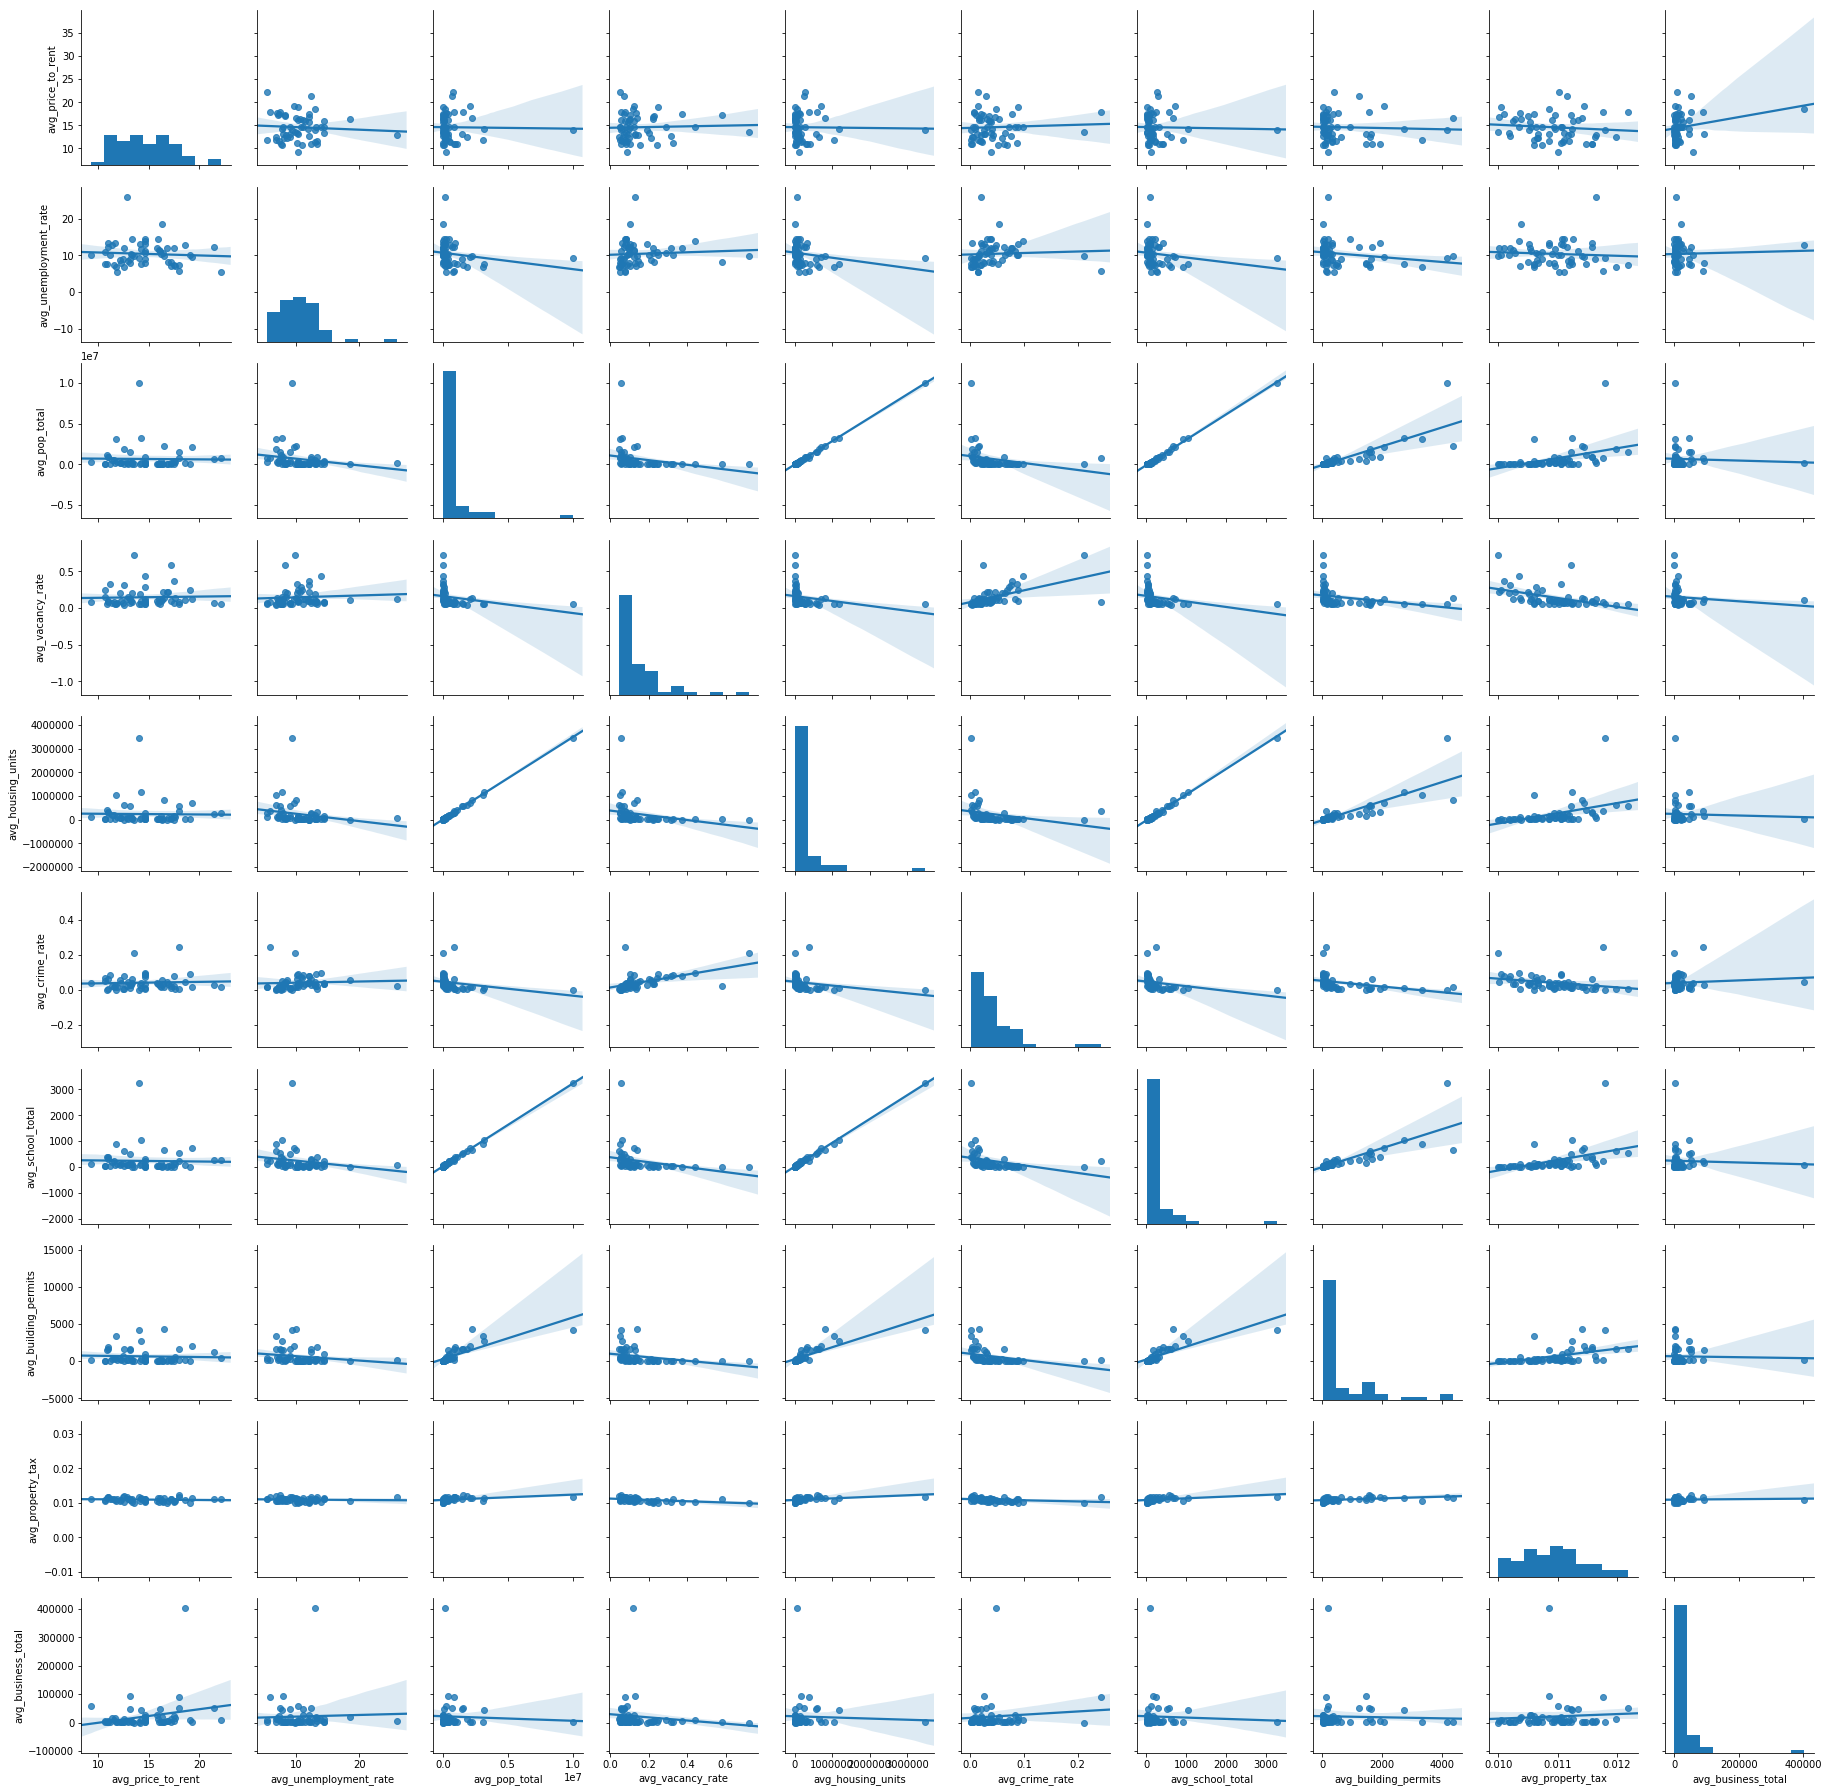

In [29]:
ca_pr["avg_price_to_rent"] = ca_pr.iloc[:,7:82].mean(axis=1)

df_list = [unemployment_rate,pop_year,vacancy_year,housing_units_year,crime_rate,sch_total,bp_year,ptax_year,bg_year]
new_col_name = ["avg_unemployment_rate","avg_pop_total","avg_vacancy_rate","avg_housing_units","avg_crime_rate","avg_school_total","avg_building_permits","avg_property_tax","avg_business_total"]
for df,col in zip(df_list,new_col_name):
    df[col] = df.mean(axis=1)

# add avg columns to dataframe for analysis
ca_market_data = pd.DataFrame()
ca_market_data["CountyName"] = crime_rate["CountyName"]
data_list = [ca_pr,unemployment_rate,pop_year,vacancy_year,housing_units_year,crime_rate,sch_total,bp_year,ptax_year,bg_year]
for data in data_list:
    col_list = list(data.columns.values)
    ca_market_data[col_list[-1]] = data[col_list[-1]]

ca_market_data["avg_price_to_rent"] = ca_market_data["avg_price_to_rent"].fillna(ca_market_data["avg_price_to_rent"].mean())
ca_market_data["avg_business_total"] = ca_market_data["avg_business_total"].fillna(ca_market_data["avg_business_total"].mean())

#display(ca_market_data)
plt.rcParams['figure.figsize']=(20,20)
sns.pairplot(ca_market_data,kind="reg")
plt.show()

Looking at the histograms for each market factor per county, there appears to be a postive skew in the data. The skewness in data could be the reason why the correlations between datasets appear to be weak when looking at the scatterplots. To get a more accurate picture of why the data is skewed, we will use boxplots to check for potential outliers in data. 

## Checking for Outliers in datasets

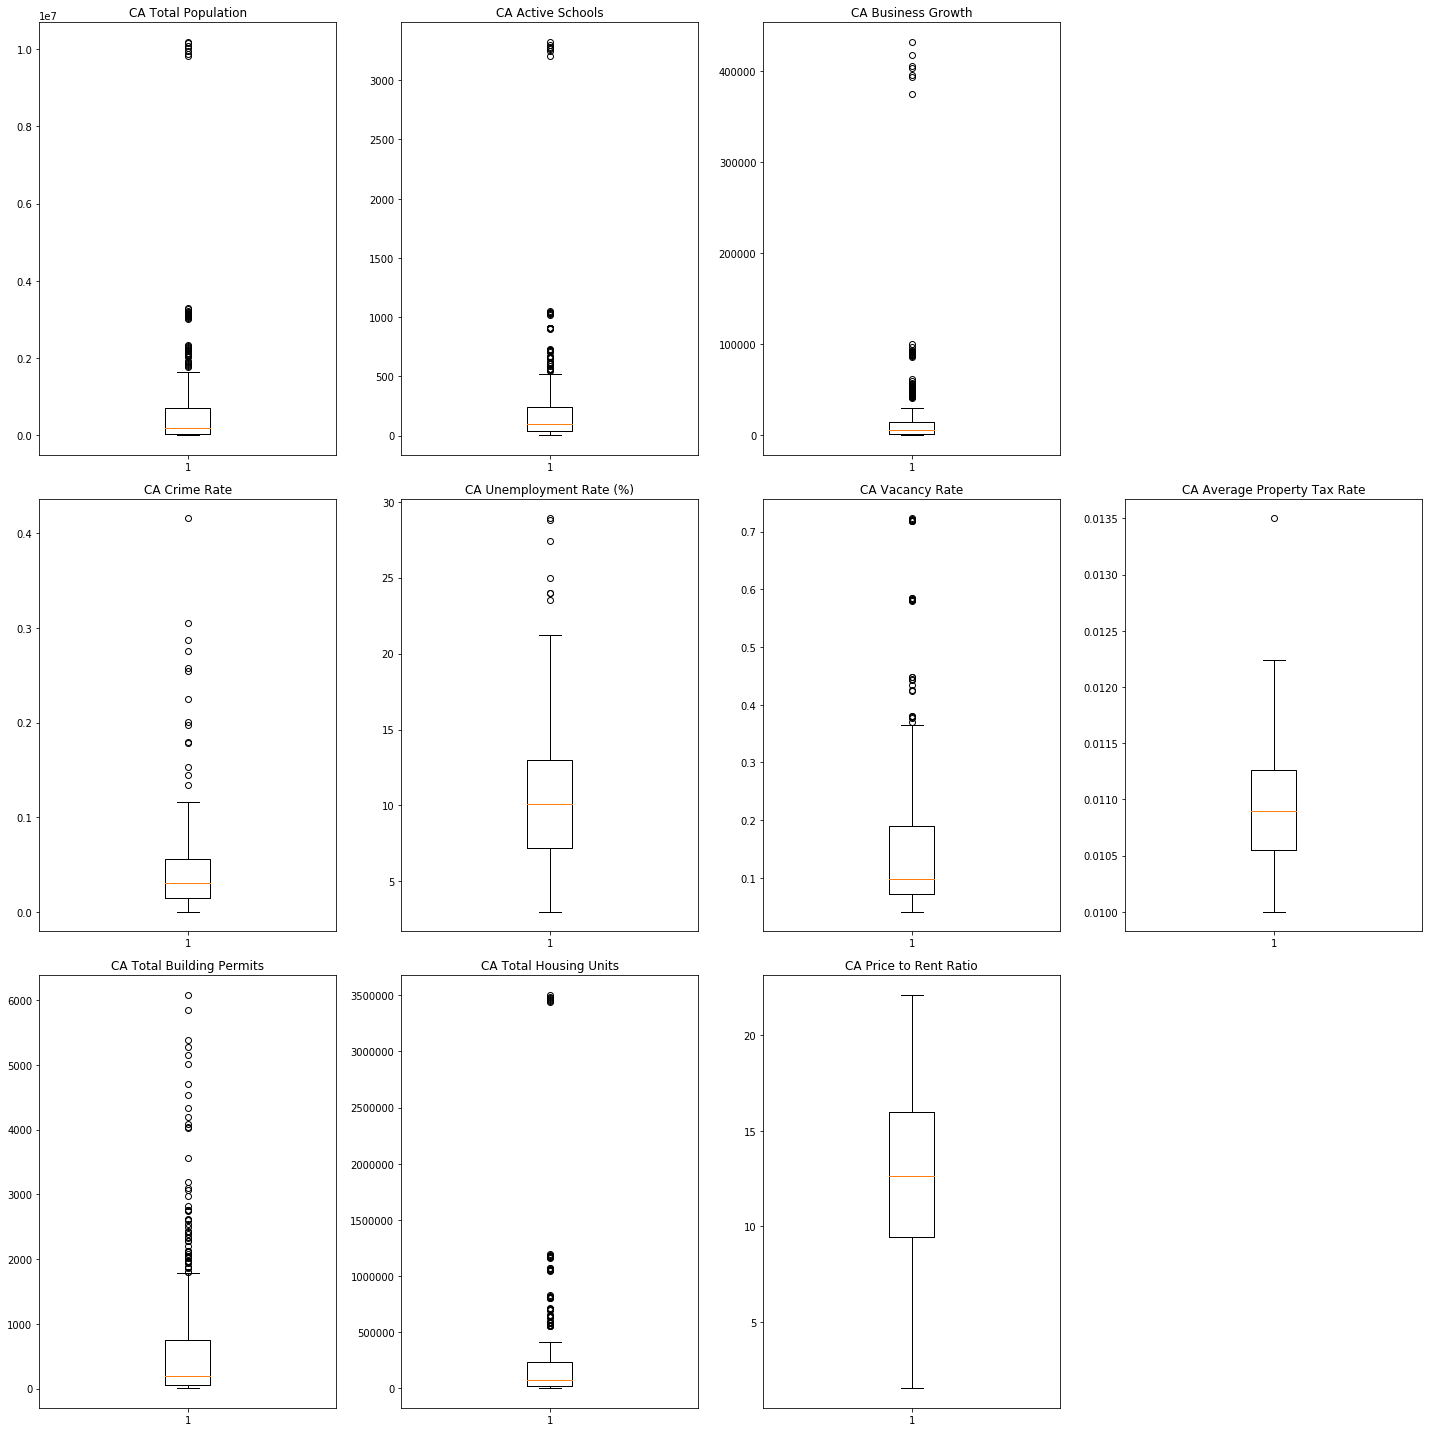

In [30]:
plt.rcParams['figure.figsize']=(20,20)
fig,ax = plt.subplots(nrows=3,ncols=4)

ax[0,0].boxplot(pop["Population Total"])
ax[0,0].set_title("CA Total Population")
ax[0,1].boxplot(sch_freq["value"])
ax[0,1].set_title("CA Active Schools")
ax[0,2].boxplot(bg_freq["value"])
ax[0,2].set_title("CA Business Growth")
ax[1,0].boxplot(cr_freq["value"])
ax[1,0].set_title("CA Crime Rate")
ax[1,1].boxplot(ur_freq["UNEMPLOYMENTRATE(%)"])
ax[1,1].set_title("CA Unemployment Rate (%)")
ax[1,2].boxplot(pop["Vacancy Rate"])
ax[1,2].set_title("CA Vacancy Rate")
ax[1,3].boxplot(ptax_freq["Average Property Tax Rate"])
ax[1,3].set_title("CA Average Property Tax Rate")
ax[2,0].boxplot(bp_data["Total_bldgs"])
ax[2,0].set_title("CA Total Building Permits")
ax[2,1].boxplot(pop["Housing Units Total"])
ax[2,1].set_title("CA Total Housing Units")
ax[2,2].boxplot(pr_freq["value"])
ax[2,2].set_title("CA Price to Rent Ratio")

for i in [3,11]:
    fig.delaxes(ax.flatten()[i])
fig.tight_layout()
plt.show()

The boxplots do not display the averages of market data per county, but rather the frequency of market value per year. Despite the difference, the plots still display a positive skew like the histograms displayed in the pairplot above. This illustrates to the viewer that the data is most likely not a normal distribution and will therefore need to be transformed and normalized to apply statistical analysis to the observations.  

## Normalizing and transforming averages for normal distribution to find correlations between datasets (2010-2016)

In [31]:
def normalize_data(df):
    x = (df-df.min())/(df.max()-df.min())
    return x

def transform_data(df):
    from scipy import stats
    x,lam = stats.boxcox(df)
    return x

In [32]:
from scipy import stats
# Population
comp_pop = ca_market_data["avg_pop_total"]
pop_trans = transform_data(comp_pop)
pop_norm = normalize_data(pop_trans)

# Price to Rent ratio
comp_pr = ca_market_data["avg_price_to_rent"]
pr_trans = transform_data(comp_pr)
pr_norm = normalize_data(pr_trans)

# Total Active Schools
comp_sch = ca_market_data["avg_school_total"]
sch_trans = transform_data(comp_sch)
sch_norm = normalize_data(sch_trans)

# Unemployment Rate
comp_ur = ca_market_data["avg_unemployment_rate"]
ur_trans = transform_data(comp_ur)
ur_norm = normalize_data(ur_trans)

# Vacancy Rate
comp_vr = ca_market_data["avg_vacancy_rate"]
vr_trans = transform_data(comp_vr)
vr_norm = normalize_data(vr_trans)
# Housing Units
comp_hu = ca_market_data["avg_housing_units"]
lmax = stats.boxcox_normmax(comp_hu, brack=(-1.9, 2.0),  method='mle')
hu_trans = stats.boxcox(comp_hu, lmax)
hu_norm = normalize_data(hu_trans)

# Crime Rate
comp_cr = ca_market_data["avg_crime_rate"]
cr_trans = transform_data(comp_cr)
cr_norm = normalize_data(cr_trans)

# Building Permits
comp_bp = ca_market_data["avg_building_permits"]
bp_trans = transform_data(comp_bp)
bp_norm = normalize_data(bp_trans)

# Property Tax
comp_ptax = ca_market_data["avg_property_tax"]
ptax_trans = transform_data(comp_ptax)
ptax_norm = normalize_data(ptax_trans)

# Business Total
comp_bg = ca_market_data["avg_business_total"]
bg_trans = stats.boxcox(comp_bg,lmax)
bg_norm = normalize_data(bg_trans)

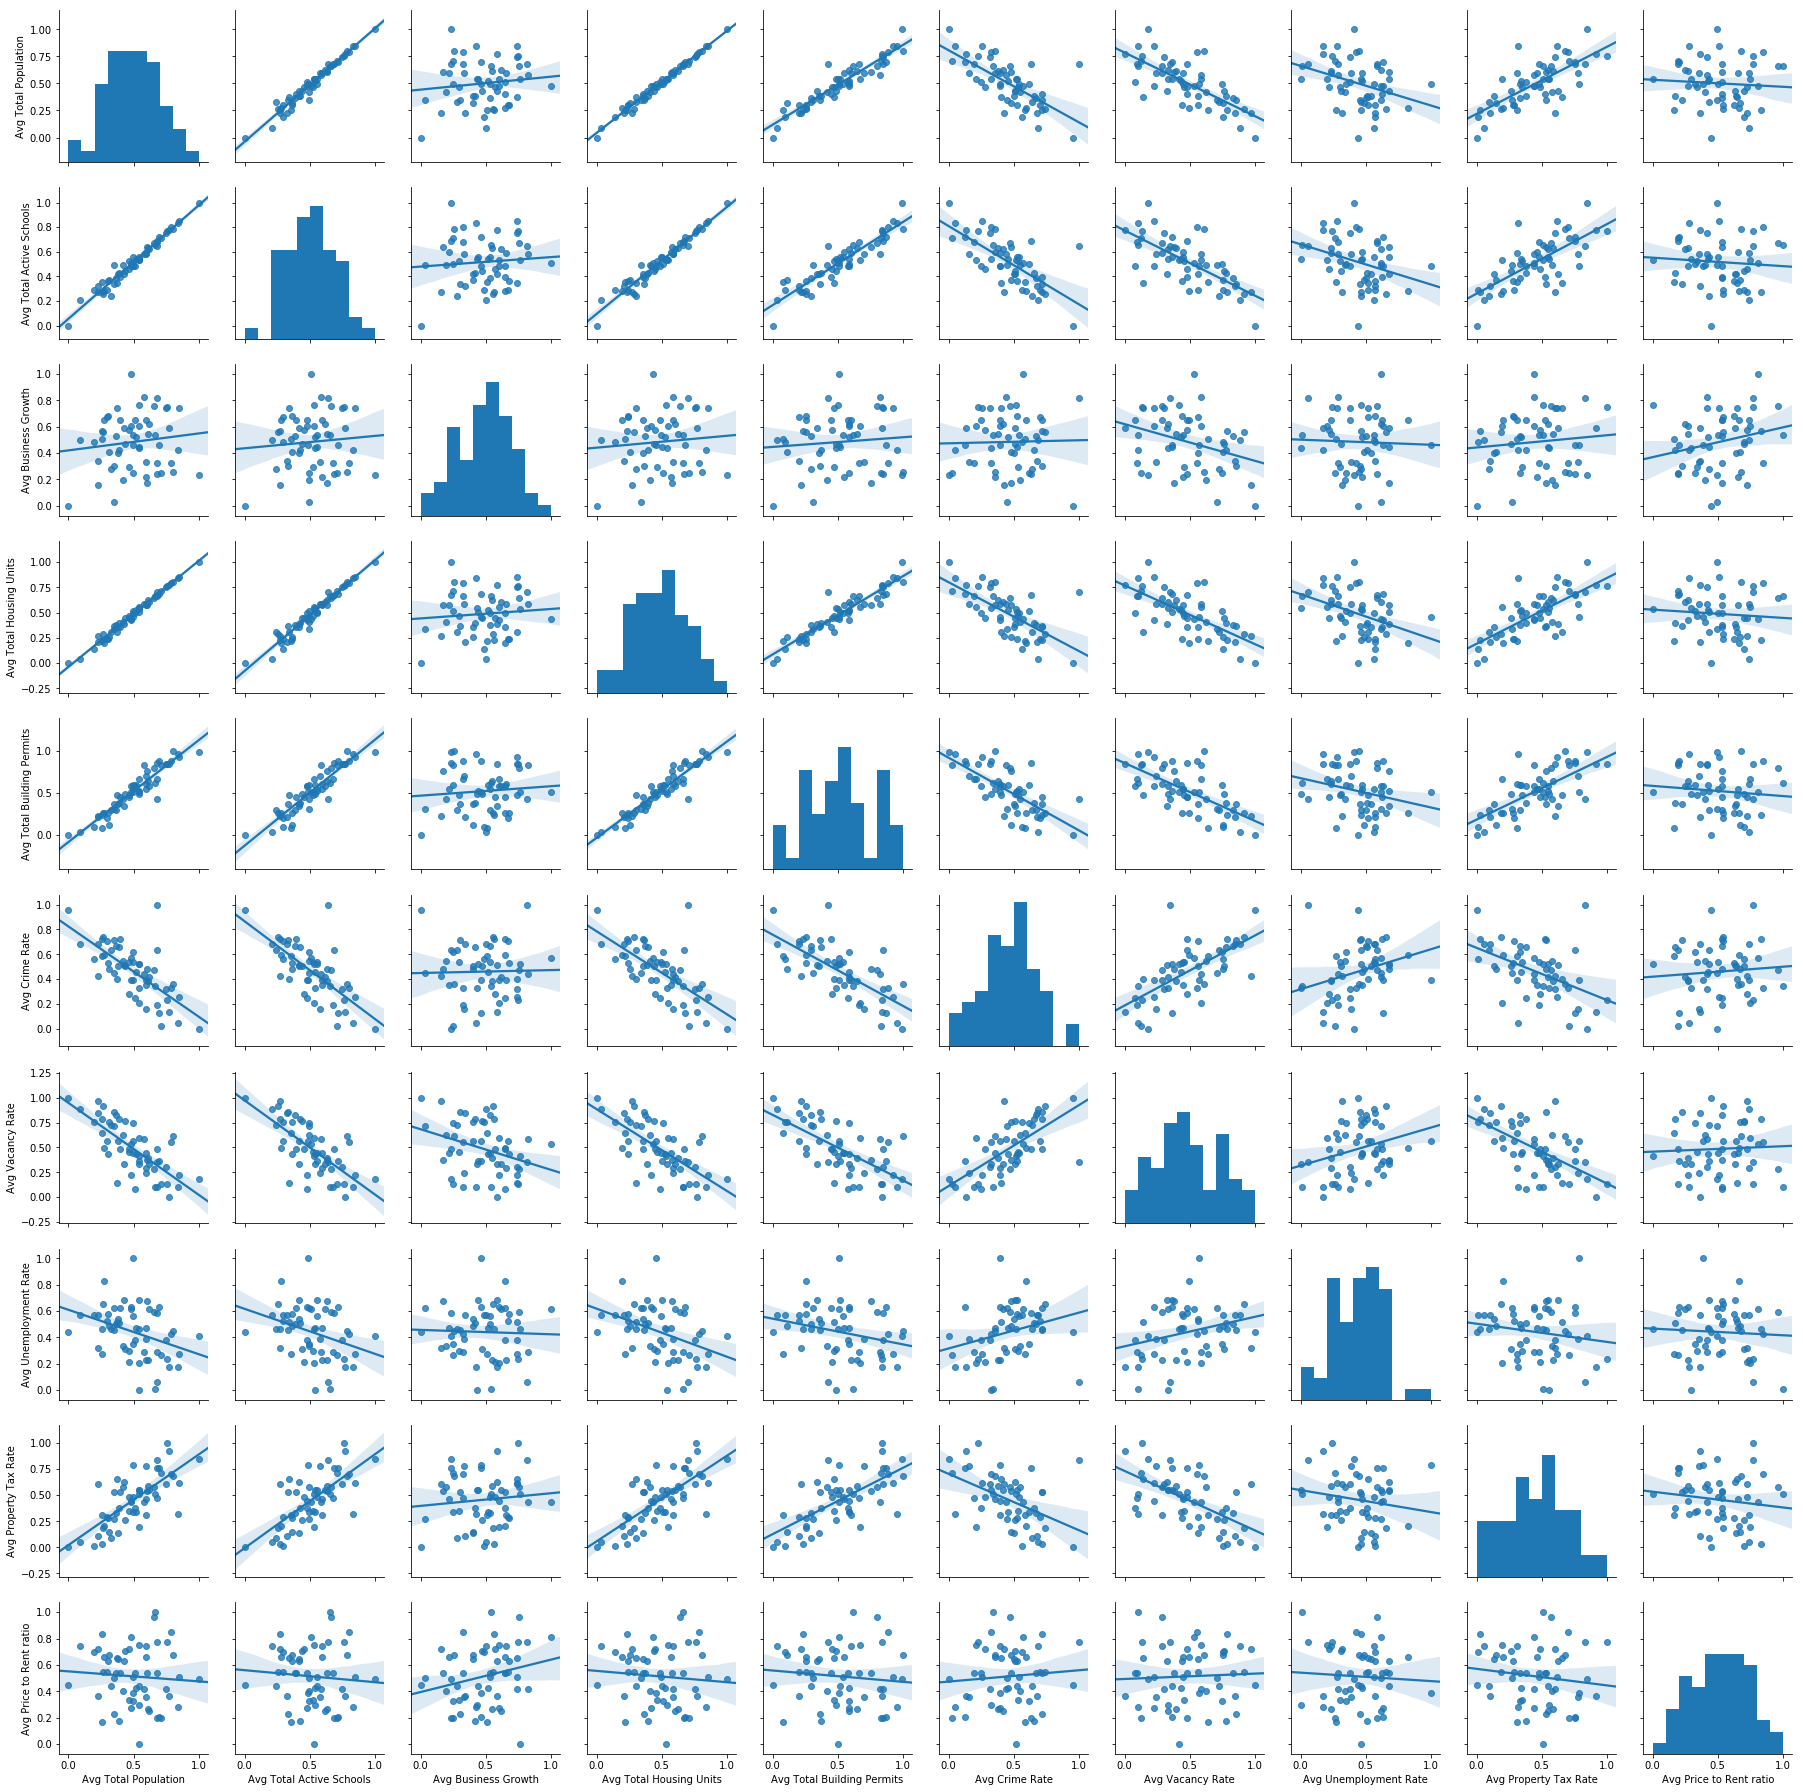

In [33]:
norm_market_data = pd.DataFrame()
data_list = [pop_norm,sch_norm,bg_norm,hu_norm,bp_norm,cr_norm,vr_norm,ur_norm,ptax_norm,pr_norm]
titles_list = ["Avg Total Population","Avg Total Active Schools","Avg Business Growth","Avg Total Housing Units","Avg Total Building Permits","Avg Crime Rate","Avg Vacancy Rate","Avg Unemployment Rate","Avg Property Tax Rate","Avg Price to Rent ratio"]

for value,title in zip(data_list,titles_list):
    norm_market_data[title] = pd.Series(value)
    
norm_market_data["CountyName"] = ca_market_data["CountyName"]                                       
sns.pairplot(norm_market_data,kind="reg")
plt.show()

##  Which real estate market factors have the strongest relationship with average total population?

With the pairplot now containing the normal distributions, we can see a more defined relationship between the real estate market factors. According to the pairplot, there appears to be a strong positive correlation between the average total population and the following market factors' averages:

1. Active Schools
2. Total Housing Units
3. Total Building Permits
4. Property Tax Rate

On the other hand, there appears to be a strong negative correlation between the average total population and the following market factors' averages:

1. Crime Rate
2. Vacancy Rate
3. Unemployment Rate

While it appears that there's a strong correlation between total population and some market factors, we still need to show the significance of the correlation using statiscal analysis. We need the pearson product-moment correlation coefficient and the p-value to help determine the strength and significance of the correlation between total population and other real estate market factors. 

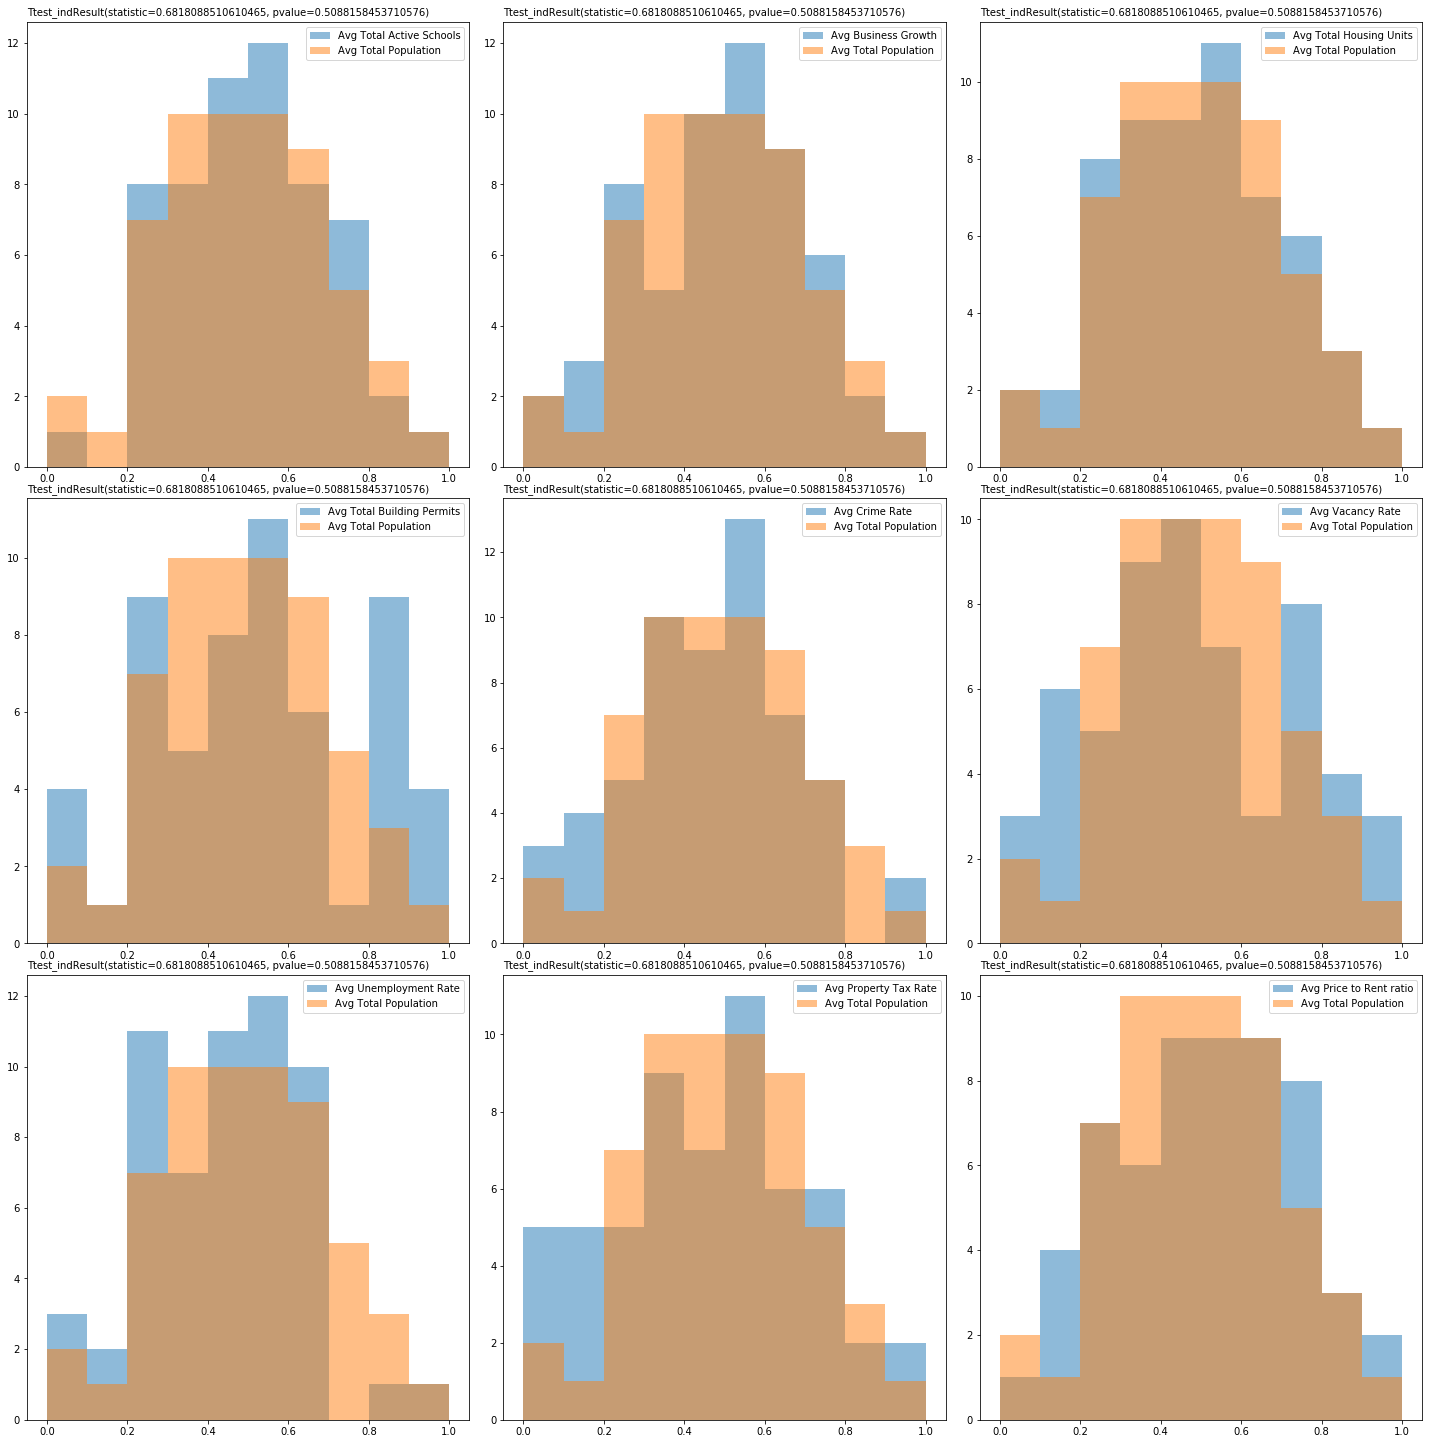

In [48]:
from scipy.stats import ttest_ind,pearsonr
values_list = [sch_norm,bg_norm,hu_norm,bp_norm,cr_norm,vr_norm,ur_norm,ptax_norm,pr_norm]
titles_list = ["Avg Total Active Schools","Avg Business Growth","Avg Total Housing Units","Avg Total Building Permits","Avg Crime Rate","Avg Vacancy Rate","Avg Unemployment Rate","Avg Property Tax Rate","Avg Price to Rent ratio"]
p_values = {}
t_values = {}

plt.rcParams['figure.figsize']=(20,20)
fig,ax = plt.subplots(nrows=3,ncols=3)
x=0
y=0
for value,title in zip(values_list,titles_list):
    t,p = ttest_ind(value, pop_norm, equal_var=False)
    ax[x,y].hist(value,alpha=0.5,label=title)
    ax[x,y].hist(pop_norm,alpha=0.5,label="Avg Total Population")
    ax[x,y].annotate(test, (0,0), (0, 460), xycoords='axes fraction', textcoords='offset points', va='top')
    ax[x,y].legend(loc='upper right')
    if title not in p_values and title not in t_values:
        p_values[title] = p
        t_values[title] = t
    if y == 2:
        x += 1
        y = 0
    else:
        y += 1


fig.tight_layout()
plt.show()

In [35]:
sorted_pvalue = sorted(p_values.items(), key=operator.itemgetter(1))
print(sorted_pvalue)

[('Avg Unemployment Rate', 0.1114567777549423), ('Avg Property Tax Rate', 0.2768555218385296), ('Avg Crime Rate', 0.29958808220422706), ('Avg Total Building Permits', 0.653613712724638), ('Avg Total Active Schools', 0.6574222870276282), ('Avg Business Growth', 0.6843191326373569), ('Avg Total Housing Units', 0.7236515546511004), ('Avg Vacancy Rate', 0.7249408868129409), ('Avg Price to Rent ratio', 0.7593160459323304)]


In [49]:
sorted_tvalues = sorted(t_values.items(),key=operator.itemgetter(1))
print(sorted_tvalues)

[('Avg Unemployment Rate', -1.6041313889008355), ('Avg Property Tax Rate', -1.092787187296692), ('Avg Crime Rate', -1.0420705724112898), ('Avg Business Growth', -0.4076186211011439), ('Avg Total Housing Units', -0.3544591050631234), ('Avg Vacancy Rate', -0.35277495984841506), ('Avg Price to Rent ratio', 0.3071195760589932), ('Avg Total Active Schools', 0.44464560905202943), ('Avg Total Building Permits', 0.4500041427053172)]


In [36]:
p_corr = {}
for value,title in zip(values_list,titles_list):
    p,p_val = pearsonr(pop_norm,value)
    if title not in p_corr:
        p_corr[title] = p
    #print(title + " vs. Total Population: \n" + "Pearson Coefficient = {}".format(p))
    #print()

In [37]:
# pearsonr correlation coefficient (strong postive or negative correlation between Total Population & )
sorted_p_corr = sorted(p_corr.items(), key=operator.itemgetter(1))
print(sorted_p_corr)

[('Avg Vacancy Rate', -0.7356410387693664), ('Avg Crime Rate', -0.6949082992330594), ('Avg Unemployment Rate', -0.35055576938388555), ('Avg Price to Rent ratio', -0.07017502699594579), ('Avg Business Growth', 0.12384941844758905), ('Avg Property Tax Rate', 0.7324722233436298), ('Avg Total Building Permits', 0.9462620826998253), ('Avg Total Active Schools', 0.9809696417718464), ('Avg Total Housing Units', 0.9938185898746192)]



The pearson product-moment correlation coefficient tells us the strength of the linear relationship between each pair of variables outlined in the pairplot above. According to the correlation coefficient, the factors with the stronges postive correlations with the average total population appear to be:

1) Average Total Housing Units

2) Average Total Active Schools

3) Average Total Building Permits

The factors with the strongest, significant negative correlations with the average total population appear to be:

1) Average Vacancy Rate

2) Average Crime Rate

3) Average Unemployment Rate

## What does this information tell us about the relationship between the average total population and other real-estate market factors in CA?

The information gathered from the pairplot, pearson correlation coefficient, and p-value tells us the following:

As the average total population increases, average total active housing units, average total active schools, and average total building permits increase as well. This makes sense since a rise in a county's population would increase demand for housing in that county. The demand for housing would prompt an increase in the need to build new houses which would cause an increase in the number of building permits filed. Likewise, an increase in the number of people in an area would also create a need for school access for children or young adults, leading to an increase in schools being built or kept active. 

On the other hand, as the average total population increases, then the average vacancy rate, average crime rate, and average unemployment rate decreases. The potential reasons for these relationships are the following:

- People tend to migrate to areas that have low crime rates, or larger populations tend to have a stronger policing system due to larger budgets (keeping crime rate low).

- Counties with large populations are indicative of having some demand or reason for additional housing (climate, schools, jobs, etc.). Therefore, larger populated areas would probably have lower vacancy rates than smaller populated areas.

- A larger population would have a larger supply of potential workers or the area has a competitive job market that draws in larger populations of people. Either case, larger populations could drive unemployment rates down. 

Flip to smaller populations:

- Areas with smaller populations tend to have fewer resources available due to a variety of factors (i.e. geographical location)

- Smaller populations have smaller demand for housing units and therefore less incentive for building permits leading to higher vacancy rates

- Less people in an area equates to higher unemployment rates due to small employment pools

- Less variety of opportunites in an area could be a factor in increasing crime rates

- Crime could also have a larger impact on smaller communities than larger communities (crimes / total population)

## Which CA county has the largest average population from 2010 to 2016?

In [38]:
population = pd.DataFrame()
pd.Series(value)
population["avg_total_pop"] = pd.Series(ca_market_data["avg_pop_total"])
population["CountyName"] = pd.Series(ca_market_data["CountyName"])

population.describe()

,avg_total_pop
count,5.800000e+01
mean,6.590832e+05
std,1.448978e+06
min,1.165714e+03
25%,4.783311e+04
50%,1.811526e+05
75%,6.622201e+05
max,1.001357e+07


In [39]:
print(list(population.loc[population['avg_total_pop'].idxmax()]))

[10013565.285714285, 'Los Angeles']


The CA county with the largest average population from 2010 to 2016 is Los Angeles County.

## Which CA county has the smallest average population from 2010 to 2016?

In [40]:
print(list(population.loc[population['avg_total_pop'].idxmin()]))

[1165.7142857142858, 'Alpine']


The CA county with the smallest average population from 2010 to 2016 is Alpine County. 

## Does the county with the largest population follow the correlations outlined in question #1? If not, what could be the reasoning for the discrepancy?

In [41]:
def extract_la(df):
    df = df[df["CountyName"]=="Los Angeles"]
    df = df.reset_index(drop=True)
    return df
# compare largest populated county with smallest populated county
# modify population,housing units and vacancy rates data
la_pop_data = pd.DataFrame()
la_pop_data = extract_la(pop)
# modify school data
la_school = extract_la(add_year_col(sch_total))
la_school = la_school[la_school["Year"] != "avg_school_total"]
la_school = la_school.rename(columns={"value":"totl_sch"})
# modify building permits data
la_bp = extract_la(bp_data[["CountyName","Year","Total_bldgs"]])
la_pop_data["Building Permits"] = pd.Series(la_bp["Total_bldgs"])
# modify crime rate data
la_cr = extract_la(cr_freq)
la_cr = la_cr.rename(columns={"value":"crime_rate"})
# modify unemployment rate % data
la_ur = lfd[["CountyName","YEAR","UNEMPLOYMENTRATE(%)"]]
la_ur["UNEMPLOYMENTRATE(%)"] = la_ur["UNEMPLOYMENTRATE(%)"].apply(pd.to_numeric,errors="coerce")
la_ur = extract_la(la_ur)
# concat data together into single dataframe
col_name = ["Total Schools","Building Permits","Crime Rate","Unemployment Rate (%)"]
old_col = ["totl_sch","Total_bldgs","crime_rate","UNEMPLOYMENTRATE(%)"]
col_values = [la_school,la_bp,la_cr,la_ur]
for name,value,col in zip(col_name,col_values,old_col):
    la_pop_data[name] = pd.Series(value[col])

# possibly transform data if data is skewed (might not need to)
la_col_name = list(la_pop_data.columns)
la_col_name.remove('CountyName')
la_col_name.remove('Year')

for col in la_col_name:
    la_pop_data[col] = normalize_data(la_pop_data[col])

/home/glenn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Los Angeles County Analysis

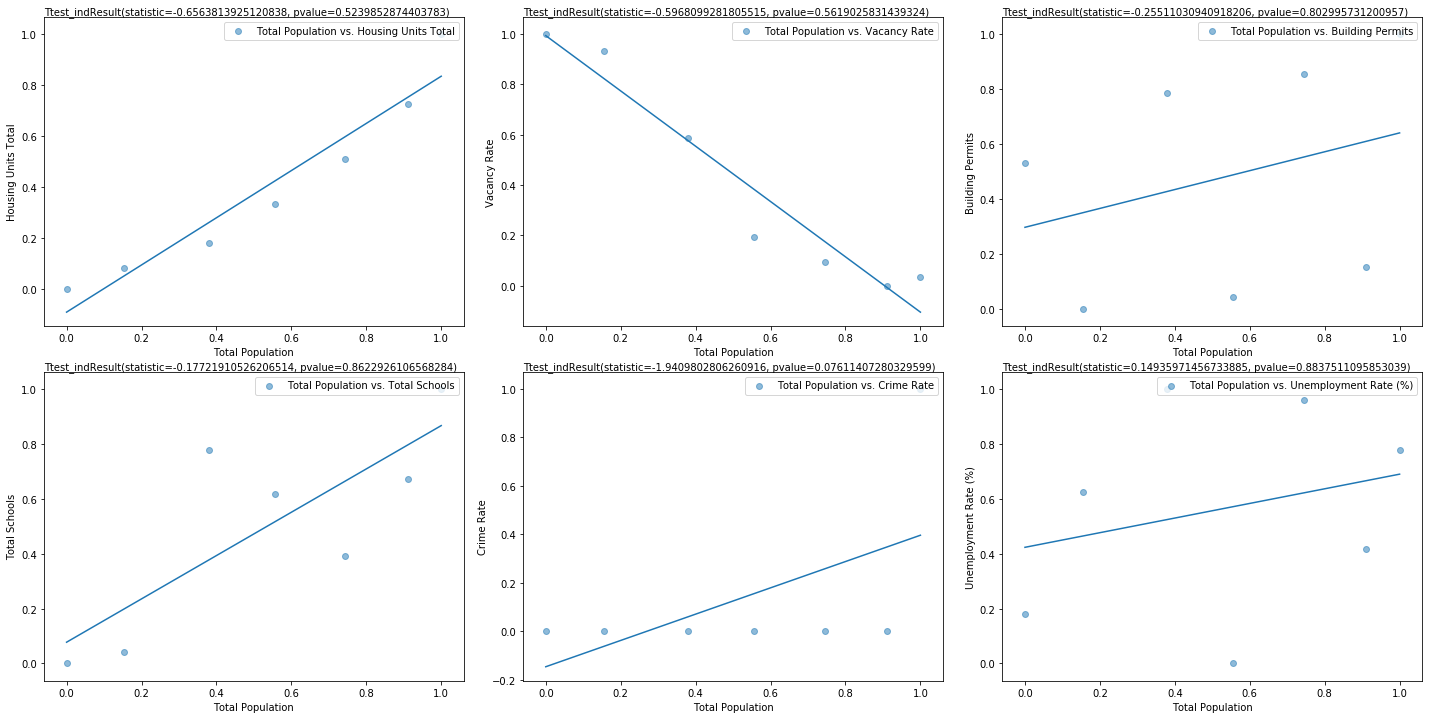

In [42]:
# plot scatter between LA market data values using normalized 
plt.rcParams['figure.figsize']=(20,10)
fig,ax = plt.subplots(nrows=2,ncols=3)
la_p_values = {}
la_p_corr = {}
x=0
y=0
for name in la_col_name[1:]:
    la_pop = la_pop_data["Population Total"]
    la_data = la_pop_data[name]
    test = ttest_ind(la_data, la_pop, equal_var=False)
    ax[x,y].scatter(la_pop,la_data,alpha=0.5,marker="o",label=("Total Population vs. {}".format(name)))
    ax[x,y].plot(np.unique(la_pop), np.poly1d(np.polyfit(la_pop, la_data, 1))(np.unique(la_pop)))
    ax[x,y].annotate(test, (0,0), (0, 320), xycoords='axes fraction', textcoords='offset points', va='top')
    ax[x,y].legend(loc='upper right')
    ax[x,y].set_xlabel('Total Population')
    ax[x,y].set_ylabel(name)
    if name not in la_p_values:
        la_p_values[name] = test.pvalue
    p,p_val = pearsonr(la_pop,la_data)
    if name not in la_p_corr:
        la_p_corr[name] = p
    if y == 2:
        x += 1
        y = 0
    else:
        y += 1


fig.tight_layout()
plt.show()

## Alpine County Analysis

In [43]:
def extract_ap(df):
    df = df[df["CountyName"]=="Alpine"]
    df = df.reset_index(drop=True)
    return df
# compare largest populated county with smallest populated county
# modify population,housing units and vacancy rates data
ap_pop_data = pd.DataFrame()
ap_pop_data = extract_ap(pop)
# modify school data
ap_school = extract_ap(add_year_col(sch_total))
ap_school = ap_school[ap_school["Year"] != "avg_school_total"]
ap_school = ap_school.rename(columns={"value":"totl_sch"})
# modify building permits data
ap_bp = extract_ap(bp_data[["CountyName","Year","Total_bldgs"]])
ap_pop_data["Building Permits"] = pd.Series(ap_bp["Total_bldgs"])
# modify crime rate data
ap_cr = extract_ap(cr_freq)
ap_cr = ap_cr.rename(columns={"value":"crime_rate"})
# modify unemployment rate % data
ap_ur = lfd[["CountyName","YEAR","UNEMPLOYMENTRATE(%)"]]
ap_ur["UNEMPLOYMENTRATE(%)"] = ap_ur["UNEMPLOYMENTRATE(%)"].apply(pd.to_numeric,errors="coerce")
ap_ur = extract_ap(ap_ur)
# concat data together into single dataframe
col_name = ["Total Schools","Building Permits","Crime Rate","Unemployment Rate (%)"]
old_col = ["totl_sch","Total_bldgs","crime_rate","UNEMPLOYMENTRATE(%)"]
col_values = [ap_school,ap_bp,ap_cr,ap_ur]
for name,value,col in zip(col_name,col_values,old_col):
    ap_pop_data[name] = pd.Series(value[col])
# normalize data
ap_col_name = list(ap_pop_data.columns)
ap_col_name.remove('CountyName')
ap_col_name.remove('Year')

for col in ap_col_name:
    ap_pop_data[col] = normalize_data(ap_pop_data[col])

/home/glenn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


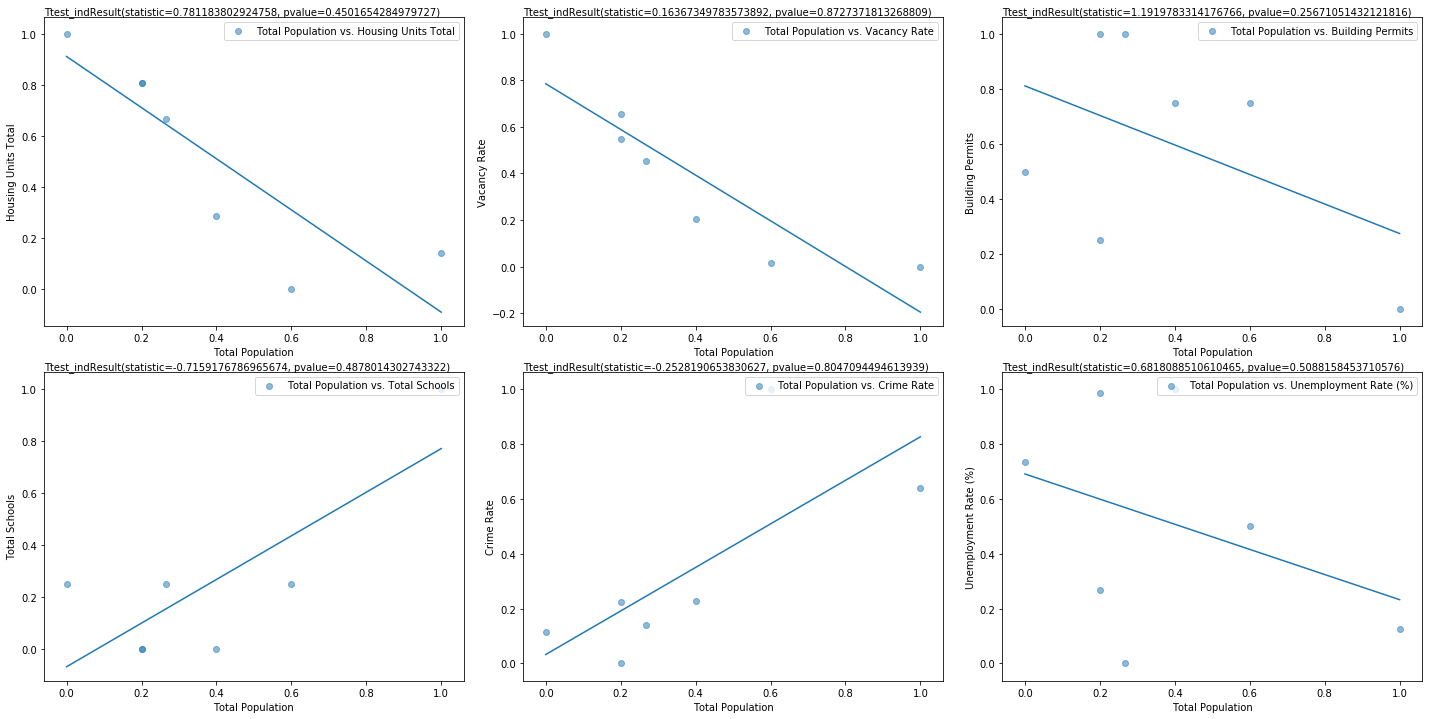

In [44]:
# plot scatter between LA market data values using normalized 
plt.rcParams['figure.figsize']=(20,10)
fig,ax = plt.subplots(nrows=2,ncols=3)
ap_p_values = {}
ap_p_corr = {}
x=0
y=0
for name in la_col_name[1:]:
    ap_pop = ap_pop_data["Population Total"]
    ap_data = ap_pop_data[name]
    test = ttest_ind(ap_data, ap_pop, equal_var=False)
    ax[x,y].scatter(ap_pop,ap_data,alpha=0.5,marker="o",label=("Total Population vs. {}".format(name)))
    ax[x,y].plot(np.unique(ap_pop), np.poly1d(np.polyfit(ap_pop, ap_data, 1))(np.unique(ap_pop)))
    ax[x,y].annotate(test, (0,0), (0, 320), xycoords='axes fraction', textcoords='offset points', va='top')
    ax[x,y].legend(loc='upper right')
    ax[x,y].set_xlabel('Total Population')
    ax[x,y].set_ylabel(name)
    if name not in ap_p_values:
        ap_p_values[name] = test.pvalue
    p,p_val = pearsonr(ap_pop,ap_data)
    if name not in ap_p_corr:
        ap_p_corr[name] = p
    if y == 2:
        x += 1
        y = 0
    else:
        y += 1


fig.tight_layout()
plt.show()

The LA county and Alpine county correlations between total population and other market factors appear to justify the claims made in the correlations in the previous analysis. The claim being that the larger a population in a given area in CA (county), the larger the number of housing units, building permits, and schools. Furthermore, we also saw that the larger the population the smaller the rates in crime, unemployment and vacancy.  This should be apparent since the analysis above had both a strong pearson correlation coefficient and a significant p-value. 

## What's going on with the crime rate in LA county?

There was one striking difference in the expected outcome when analyzing LA and Alpine County, and it was that crime rate appeared to have a positive correlation with total population in both counties. We should have expected a negative correlation between crime rate and total population in LA county, given that it had the largest average population between 2010 to 2016. What gives?

In [45]:
sorted_la_p_corr = sorted(la_p_corr.items(), key=operator.itemgetter(1))
sorted_la_p_value = sorted(la_p_values.items(), key=operator.itemgetter(1))
print("LA county: ")
print()
print("Pearsonr Correlation Coefficient: ")
print(sorted_la_p_corr)
print()
print("P-values: ")
print(sorted_la_p_value)

LA county: 

Pearsonr Correlation Coefficient: 
[('Vacancy Rate', -0.9661944555297914), ('Unemployment Rate (%)', 0.26273743193439686), ('Building Permits', 0.31280827573625614), ('Crime Rate', 0.5423569968509764), ('Total Schools', 0.7960437872076273), ('Housing Units Total', 0.9617256787181133)]

P-values: 
[('Crime Rate', 0.07611407280329599), ('Housing Units Total', 0.5239852874403783), ('Vacancy Rate', 0.5619025831439324), ('Building Permits', 0.802995731200957), ('Total Schools', 0.8622926106568284), ('Unemployment Rate (%)', 0.8837511095853039)]


In [46]:
display(la_cr)

,CountyName,Year,crime_rate
0,Los Angeles,2010,4.073898e-07
1,Los Angeles,2011,1.113937e-06
2,Los Angeles,2012,0.000000e+00
3,Los Angeles,2013,4.989364e-07
4,Los Angeles,2014,2.378629e-06
5,Los Angeles,2015,3.940647e-07
6,Los Angeles,2016,9.828477e-03


The 0.076 p-value indicates that the correlation between LA county's crime rate and its population is marginal. In other words, it's unclear whether the crime rate is correlated with the population in LA county. Possible reasons for this ambiguity are:

- There appears to be some outliers in the data that could skew the data.

- There could also have been special cases that contribute to the outlying data (more crimes reported during a certain year or missing reports)


## Comparing price to rent ratios between the largest and smallest populated CA counties

The price-to-rent ratio is a statistic that is used for comparing the relative costs of buying and renting to help determine the best locations to buy or rent houses. Typically, a lower price-to-rent ratio indicates that a location is more suitable for home buyers and a higher ratio indicates a renters' market.

Equation: "P/R" = Average Property Price / Average Rent per year:

If the average price of a home in a market is 100,000 and the average monthly rent is 1,000, the PR is 8.83. The PR of another market with average property worth 150,000 and average rent 1,200 per month is 10.41.

Market 1 "P/R" = 100,000 / (12 x 1,000) = 8.83

Market 2 "P/R" = 150,000 / (12 x 1,200) = 10.41

Market 1 would be a stronger buyers' market than Market 2, and Market 2 would be a stronger renters' market than Market 1 given the information provided.

Potential Downside of Price-to-Rent Ratio: Does not measure locations' housing affordability. An area where renting & buying are very expensive could have the same price-to-rent ratio as an area where renting & buying are very cheap.

For this analysis, we will substitute Alpine County with Inyo County which has a similar population density (18,557 total population) because Zillow, unfortunately, does not have the price to rent ratio for Alpine County. 

In [47]:
la_pr = ca_pr.loc[ca_pr['CountyName']=='Los Angeles','avg_price_to_rent'].iloc[0]
in_pr = ca_pr.loc[ca_pr['CountyName']=='Inyo','avg_price_to_rent'].iloc[0]
print("Los Angeles County's average price to rent ratio from 2010 to 2016 is : {}".format(la_pr))
print()
print("Inyo County's average price to rent ratio from 2010 to 2016 is : {}".format(in_pr))
#display(ca_pr)

Los Angeles County's average price to rent ratio from 2010 to 2016 is : 16.416502525252525

Inyo County's average price to rent ratio from 2010 to 2016 is : 12.846666666666666


We stated above that the lower the price to rent ratio, the stronger the buyers' market is for housing in a particular area (county). In this case, Inyo County has a relatively smaller price to rent ratio than Los Angeles County which would suggest that Inyo is a better place to buy a house than Los Angeles. On the other hand, since Los Angeles has the higher price to rent ratio compared to Inyo, then Los Angeles would be a better place to rent a house than Inyo. 

This relationship makes sense since areas with larger populations tend to have a larger competition for housing than lower populated areas (as shown in the analysis above). In other words, larger populated areas could be a indicator of higher price to rent ratios than smaller populated areas. We would probably need to compare a larger sample of CA counties before coming to a definitive conculsion, but this small comparison does outline some interesting questions. 

Some further areas of analysis that may warrant further investigation:

- How does geographical location relate to lower or higher populated areas?

- Can the crime rate be applied to counties with less than 100,000 population? Does that have an affect on the relationship between crime rate and smaller populated counties?

- How do counties in CA compare with counties in other states using the same variables in this analysis?

## Conclusion

We have found many interesting relationships between the total population and other real estate market factors in CA counties between 2010 and 2016:

1. CA counties with larger populations tend to have on average, more housing units, building permit applications, and more schools.

2. These large counties also tend to have on average, lower unemployment rates, crime rates, and lower vacancy rates.

3. Found some errors with crime rate when performing our sample analysis and determined that there could be special case errors in certain counties.

4. Los Angeles had the largest average population from 2010 to 2016 in CA.

5. CA counties with larger populations could be an indicator for higher price to rent ratios which could be prove that price to rent ratios have a stronger correlation to the total population than we were led to believe with the pairplot analysis. 